# Modeling Uncertainty in Random Forests and Neural Networks

This notebook produces scikit-garden and TFP predicitons for LAI and fAPAR for the NAIVE dataset for each biome and, using the validation datasets, compares the predicted confidence intervals to:
1. **Epistemic error** (Cross validation error)
2. **Aleatoric error** (The standard deviation of LAI and fAPAR given in the algorithm)

## 0 Inital Setup

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import modules
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
# List of biome numbers
# This can be used to easily create models and predictions for all biomes by applying a for loop
# For now we will only use one biome (specifically biome 7)
biomes = [1,2,3,4,5,6,7,8]

### 0.1 Dataframe Structure
The datasets used in this notebook is stored in two separate dictionaries. Both dictionary are organized by biome number, with each biome containing a dictionary holding the corresponding dataframe. 

- **calbiomeDictLAI**: this dictionary contains the calibration datasets.
- **valbiomeDictLAI**: this dictionary contains the validation datasets.

For example, `valbiomeDictLAI[7]['DF']` is used to access the validation dataset of biome 7.

The dictionaries used in this notebook can be found here: https://drive.google.com/drive/folders/17pL6zsZqGIPmJt5ChS_wxqVuZHdZa4Lg?usp=sharing 

In [6]:
# Read in dataset
calbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/calbiomeDictLAI.pkl')
valbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/valbiomeDictLAI.pkl')

In [342]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

valSize = [100, 1000]

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF']

    calbiomeDictLAI[i]['X_train'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train'] = dfcal[response]
    
    for size in valSize:
        dfval = valbiomeDictLAI[i]['DF'].sample(size)
        valbiomeDictLAI[i]['X_test_' + str(size)] = dfval[regressors]
        valbiomeDictLAI[i]['y_test_' + str(size)] = dfval[response]

## 1 Random Forest

In [8]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### 1.1 Random Forest Regression

#### Background Information
A **random forest** is an ensemble model that consists of many **decision trees** and predictions are made by averaging the predictions of each decision tree. In this notebook, we will use *scikit-learn* to implement the random forest regressor.

#### Defining the Model
First we will need to define our random forest regression model with some basic parameters. We will use 100 trees in our forest. The minimum number of samples required to be at a leaf node is 10, the maximum number of features to consider when looking for the best split is set to 5, and the maximum number of leaf nodes is 10000.

We will use the default function to measure the quality of a split, which is **mean squared error**.

In [9]:
# Creating and fitting a Random Forest Regressor for biome 7 with 100 trees
biome = 7
valbiomeDictLAI[biome]['rf'] = dict()
valbiomeDictLAI[biome]['rf']['model'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,n_jobs=-1,max_leaf_nodes=10000)

#### Training the Model
To train our model, we call the `fit` method and pass our training data as parameters.

In [10]:
valbiomeDictLAI[biome]['rf']['model'] = valbiomeDictLAI[biome]['rf']['model'].fit(calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'])

#### Making Predictions


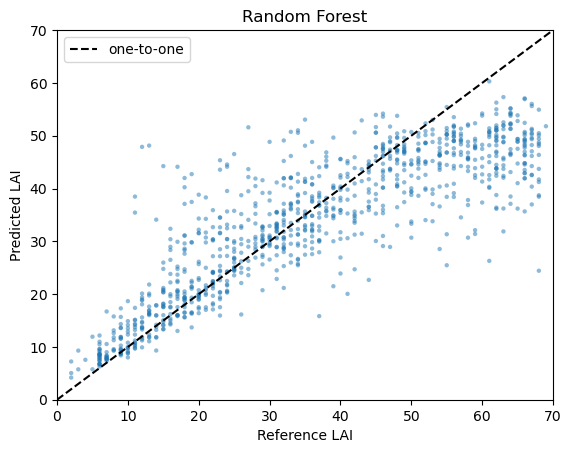

In [17]:
# Plotting the Quantile Regression Forest with error bars
valbiomeDictLAI[biome]['rf']['y_pred'] = valbiomeDictLAI[biome]['rf']['model'].predict(valbiomeDictLAI[biome]['X_test_1000'])

plt.scatter(valbiomeDictLAI[biome]['y_test_1000'], valbiomeDictLAI[biome]['rf']['y_pred'], s=10, alpha=0.5, edgecolors='none')
plt.plot([0, 70], [0, 70], 'k--', label='one-to-one')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend()
plt.show()

### Random Forest Quantile Regression

To use Scikit-Garden:

| Package       | Version          | Notes                    |
|:--------------|:-----------------|:-------------------------|
| python        | 3.7              |                          |
| numpy         | 1.21  (default)  |                          |
| matplotlib    | 3.5   (default)  |                          |
| pandas        | 1.2   (default)  |                          |
| scikit-learn  | 0.22  (default)  |                          |
| scikit-garden | 0.1.3 (default)  | install with conda-forge |
| jupyterlab    | 3.6   (default)  | install with pip         |

In [12]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

#### Background Information


#### Defining the Model
We can define the random forest quantile regressor model with the same parameters as our random forest regressor above. Again we will use 100 trees.

In [13]:
# Creating a Random Forest Quantile Regressor (100 trees per forest)
biome = 7
valbiomeDictLAI[biome]['rfqr'] = dict()
valbiomeDictLAI[biome]['rfqr']['model'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

#### Training our Model
Again, to train our model, we call the `fit` method and pass our training data as parameters.

In [14]:
# Fitting a Random Forest Quantile Regressor for each biome type
valbiomeDictLAI[biome]['rfqr']['model'] = valbiomeDictLAI[biome]['rfqr']['model'].fit(calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'])

#### Making Predictions
Similar to the random forest regressor, we can make prediction with our model using the `.predict()` method. The difference is that we will specify the quantiles at which we want our predictions. In this case, we will specify the upper quantile at 98.5 and the lower quantile at 2.5, giving us a 95% prediction interval. If the quantile is not set, the model will return the expected value.

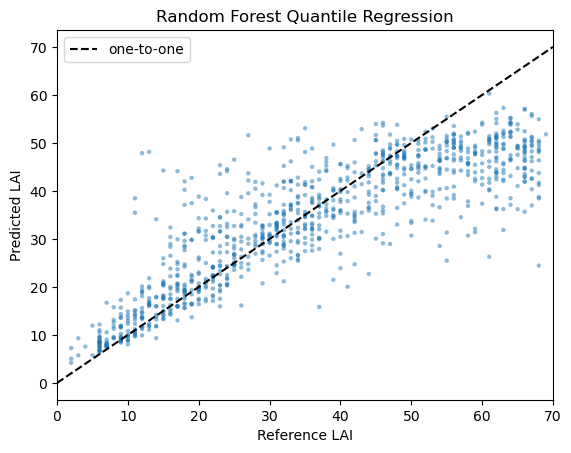

In [18]:
# Predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
valbiomeDictLAI[biome]['rfqr']['upper'] = valbiomeDictLAI[biome]['rfqr']['model'].predict(valbiomeDictLAI[biome]['X_test_1000'], quantile=98.5)
valbiomeDictLAI[biome]['rfqr']['lower'] = valbiomeDictLAI[biome]['rfqr']['model'].predict(valbiomeDictLAI[biome]['X_test_1000'], quantile=2.5)
valbiomeDictLAI[biome]['rfqr']['y_pred'] = valbiomeDictLAI[biome]['rfqr']['model'].predict(valbiomeDictLAI[biome]['X_test_1000'])

# Plotting the Quantile Regression Forest with error bars
# plt.scatter(valbiomeDictLAI[biome]['y_test'], valbiomeDictLAI[biome]['DF']['upper'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
# plt.scatter(valbiomeDictLAI[biome]['y_test'], valbiomeDictLAI[biome]['DF']['lower'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
plt.scatter(valbiomeDictLAI[biome]['y_test_1000'], valbiomeDictLAI[biome]['rfqr']['y_pred'], s=10, alpha=0.5, edgecolors='none')
plt.plot([0, 70], [0, 70], 'k--', label='one-to-one')

plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest Quantile Regression')

plt.xlim([0, 70])
# plt.ylim([-50, 120])

plt.legend()
plt.show()

### Comparing Random Forest and Quantile Forest

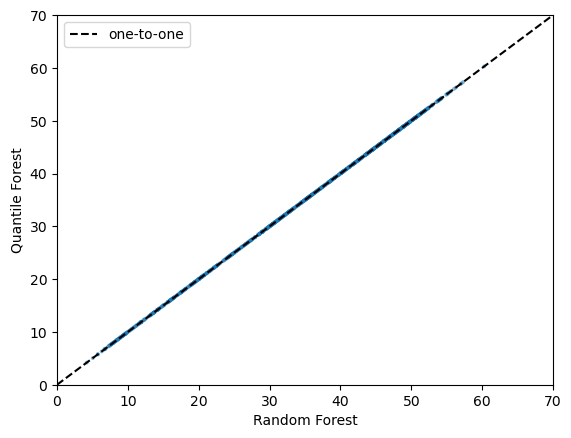

In [19]:
plt.scatter(valbiomeDictLAI[biome]['rf']['y_pred'], valbiomeDictLAI[biome]['rfqr']['y_pred'], s=8, alpha=0.5, edgecolors='none')
    
plt.plot([0, 70], [0, 70], 'k--', label='one-to-one')
plt.xlabel("Random Forest")
plt.ylabel("Quantile Forest")
# plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend()
plt.show()

## 2 Neural Network

### 2.0 Dataframe Structure
`valbiomeDictLAI[biome#]` is a dictionary that will hold another dictionary with naming convention `[type of neural network]_[#neurons]_..._[output shape]_[Type of Error/None]`.

**Examples:** \
`nn_80_25_1` is a regular neural network with 2 hidden layers, 80 neurons in the first and 25 in the second, with output shape 1.\
`pnn_8_1` is a probabilistic neural network with 1 hidden layer with 8 neurons and output shape 1 that measure aleatoric and epistemic error.\
`pnn_8_2_1_A` is a probabilistic neural network with 2 hidden layer with 8 neurons in the first and 2 in the second and output shape 1. This network measures aleatoric error only.

Each of these dictionaries will hold information about the model, the history, the number of parameters, etc.

### 2.1 Regular Neural Network

In [20]:
# Import Modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

#### 2.1.1 Normalizing the Input Data
Before defining the model, we first normalize the inputs using the Keras `Normalization()` layer to transform the data to be on a similar scale. We call the `adapt()` method on our input data to get the mean and standard deviation of the dataset and set our normalization layer to use those parameters.

In [21]:
normalizer = layers.Normalization(input_shape=[5,], axis=None)
normalizer.adapt(np.array(calbiomeDictLAI[biome]['X_train']))

#### 2.1.2 Defining the Model
To build our model, we will use `keras.Sequnential()`, which groups a linear stack of layers into a `keras.Model()`. It also provides training and inference features on this model.

The first layer in our model is the normalizer we defined above. The subsequent layers are all `Dense()` (interconnected) layers. The parameter `units` sets the number of neurons in each layer. In our case, we create a 2 hidden layer network with 80 neurons in the first and 25 in the second. The `activation` parameter specifies an activation function. This is the function that decides whether a particular neuron in the layer should be taken into account. We use a **relu** activation function to add non-linearity to the network.

Now that we've defined our model, we need to compile it by specifying a loss function and an optimizer. For consistency, we will use the **mean squared error** as our loss function as this is the loss function used in *scikit-learn*'s Random Forest. The optimizer we will use is **Adam**, with a learning rate of of **0.01**. We can also include any desired metrics using the `metrics` parameter. For now, we will only include the **root mean squared error**.


Finally we will print out a summary table of our model to see the number of parameters in each layer.

In [32]:
# Name of the Network
name = 'nn_80_25_1'
# Biome number 
biome = 7

# Create a new dictionary to save the Network
valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=80, activation='relu'),
    layers.Dense(units=25, activation='relu'),
    layers.Dense(units=1)
])

# Compile the model with the specified loss and optimizer functions
valbiomeDictLAI[biome][name]['model'].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 80)                480       
                                                                 
 dense_7 (Dense)             (None, 25)                2025      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,534
Trainable params: 2,531
Non-trainable params: 3
_________________________________________________________________


#### 2.1.3 Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 52s 4ms/step - loss: 90.1169 - root_mean_squared_error: 9.4930
Epoch 2/50
11771/11771 [==============================] - 67s 6ms/step - loss: 83.6713 - root_mean_squared_error: 9.1472
Epoch 3/50
11771/11771 [==============================] - 48s 4ms/step - loss: 83.0047 - root_mean_squared_error: 9.1107
Epoch 4/50
11771/11771 [==============================] - 51s 4ms/step - loss: 82.5575 - root_mean_squared_error: 9.0861
Epoch 5/50
11771/11771 [==============================] - 46s 4ms/step - loss: 81.9817 - root_mean_squared_error: 9.0544
Epoch 6/50
11771/11771 [==============================] - 49s 4ms/step - loss: 80.9744 - root_mean_squared_error: 8.9986
Epoch 7/50
11771/11771 [==============================] - 48s 4ms/step - loss: 76.1385 - root_mean_squared_error: 8.7257
Epoch 8/50
11771/11771 [==============================] - 48s 4ms/step - loss: 74.8796 - root_mean_squared_error: 8.6533
Epoch 9/50
11771/11771 [========

Text(0, 0.5, 'Loss')

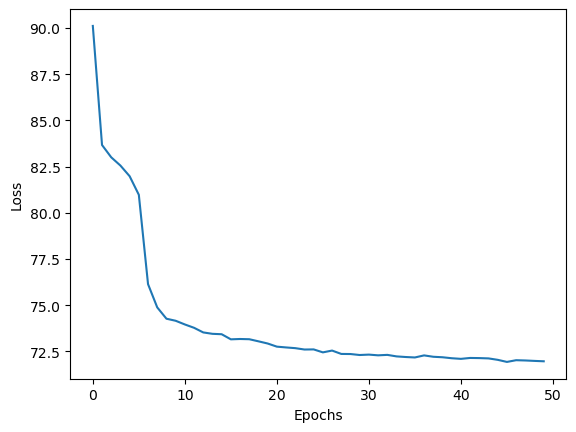

In [33]:
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.1.1** Loss convergence trained over 50 epochs for a regular 80-25-1 neural network. Loss converges indicating the model has been correctly trained._

#### 2.1.4 Making Predictions
Now that our model has been trained, we can start making predictions using our validation dataset. To visual our predictions, we can scatterplot the predicted results against the reference values.

In [348]:
name = 'nn_80_25_1'
biome = 7

valSize = [100, 1000]

for size in valSize: 
    valbiomeDictLAI[biome][name]['y_pred_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)]).flatten()

32/32 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 4ms/step


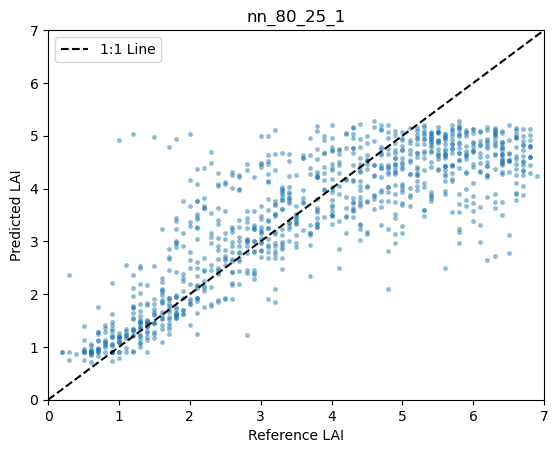

In [338]:
name = 'nn_80_25_1'
biome = 7

plt.scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['y_pred_1000'], 10), alpha=0.5, s=12, lw=0)
plt.plot([0, 7], [0, 7], 'k--', label='1:1 Line')

plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title(name)

plt.xlim([0, 7])
plt.ylim([0, 7])
plt.legend()
plt.show()

_**Figure 2.1.2** Predicted LAI from a regular 80-25-1 neural network in comparison to the reference LAI for 1000 samples. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### 2.2 Aleatoric Uncertainty

#### 2.2.0 Background Information
**Aleatoric Uncertainity**, or data uncertainty, relates to the data generating process that produces our data and captures the unpredictable randomness in outcomes when repeating the same experiement with exactly the same settings many times. The most important fact about aleatoric uncertainty is that it cannot be reduced by adding more data.

#### 2.2.1 Defining a log-likelihood Loss Function
We first create a function that takes some data and distribution object and computes log-liklihood of the data given to the distribution. Like any TensorFlow-compatible loss function, the function takes true values `y_true` and predictions `y_pred`. Then we compute the log-PDF with the `log_prob()` method and reverse the sign to maximize the liklihood. 

In [35]:
negloglik = lambda y_true, y_pred: -y_pred.log_prob(y_true)

#### 2.2.2 Defining the Model
The first layer of our model is the same normalizer we've defined before to normalize our input data.

The next three layers are regular Keras `Dense` layers. The third `Dense()` layer's purpose is to parametrize the distribution in the last layer. There are 2 output nodes —— mean and standard deviation.

The last layer is a `DistributionLambda()` layer, a special Keras layer that uses a Python lambda to construct a distribution conditioned on the layer input. In this case, we are using a normal distribution.

`softplus` is a smooth approximation of relu. Like relu, softplus always takes on positive values.softplus is a smooth approximation of relu. Like relu, softplus always takes on positive values.

In [71]:
# Name of the Network
name = 'pnn_80_25_1_A'
# Biome number 
biome = 7

# Create a new dictionary to save the Network
valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(80, activation='relu'),
    layers.Dense(25, activation='relu'),
    layers.Dense(2), # 2 outputs — mean and stddev
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik, metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 80)                480       
                                                                 
 dense_13 (Dense)            (None, 25)                2025      
                                                                 
 dense_14 (Dense)            (None, 2)                 52        
                                                                 
 distribution_lambda_4 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2,560
Trainable params: 2,557
Non-train

#### 2.2.3 Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 28s 2ms/step - loss: 4.8549 - root_mean_squared_error: 15.4621
Epoch 2/50
11771/11771 [==============================] - 25s 2ms/step - loss: 3.4672 - root_mean_squared_error: 12.8676
Epoch 3/50
11771/11771 [==============================] - 25s 2ms/step - loss: 3.4206 - root_mean_squared_error: 12.3821
Epoch 4/50
11771/11771 [==============================] - 25s 2ms/step - loss: 3.4075 - root_mean_squared_error: 12.2825
Epoch 5/50
11771/11771 [==============================] - 24s 2ms/step - loss: 3.4008 - root_mean_squared_error: 12.2366
Epoch 6/50
11771/11771 [==============================] - 24s 2ms/step - loss: 3.3963 - root_mean_squared_error: 12.1968
Epoch 7/50
11771/11771 [==============================] - 24s 2ms/step - loss: 3.3921 - root_mean_squared_error: 12.1591
Epoch 8/50
11771/11771 [==============================] - 24s 2ms/step - loss: 3.3877 - root_mean_squared_error: 12.1208
Epoch 9/50
11771/11771 [========

Text(0, 0.5, 'Loss')

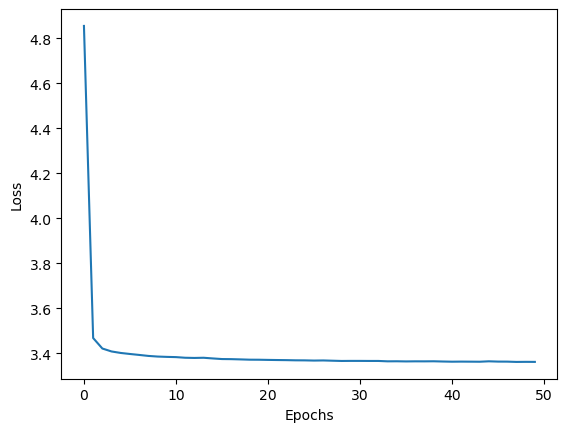

In [72]:
# Train the model for 50 epochs
name = 'pnn_80_25_1_A'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

_**Figure 2.2.1** Loss convergence trained over 50 epochs for a probabilistic 80-25-1 neural network predicting aleatoric uncertainty. Loss converges, indicating the model has been correctly trained._

#### 2.2.4 Making Predictions

In [359]:
name = 'pnn_80_25_1_A'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['error_' + str(size)] = 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]

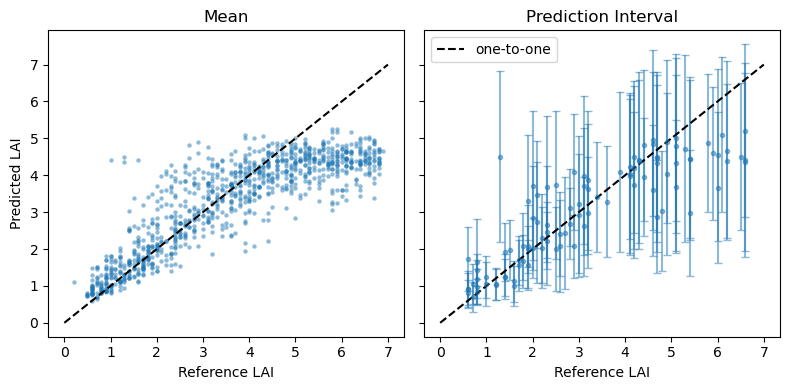

In [363]:
name = 'pnn_80_25_1_A'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], 10), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_100'], 10), np.divide(valbiomeDictLAI[biome][name]['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

plt.legend()
plt.show()

_**Figure 2.2.2** Predicted LAI with aleatoric uncertainity from a probabilistic 80-25-1 neural network in comparison to the reference LAI. Error bars indicate the standard deviation of each prediction. A one-to-one is plotted to show relatively how well the predictions are. It can be observed that for LAI values greater than 4.5, the model tends to underpredict. This behaviour is expected._

### Epistemic Uncertainty

#### Sources
Probabilistic regression with Tensorflow: https://ekamperi.github.io/machine%20learning/2021/01/07/probabilistic-regression-with-tensorflow.html \
Modeling uncertainity in neural networks with TensorFlow Probability: https://towardsdatascience.com/modeling-uncertainty-in-neural-networks-with-tensorflow-probability-d519a4426e9c

#### Background Information
**Epistemic uncertainty** or model uncertainty is related to our knowledge regarding the data generating process. For example, the uncertainty regarding which parameters accurately model the experimental data. 

Epistemic uncertainty can be decreased by adding more training data. Its modeling is realized by enabling a neural network's wieghts to be probabilistic rather than deterministic,

#### Prior Distribution
We first need to define a prior distribution for our model's weights. Adopting a normal distribution as a prior is a good way to initalize a probabilistic neural network. As the **central limit theorem** assets, a properly normalized sum of samples will approximate a normal distribution no matter the actual underlying distribution.

Here we used a `Independent()` `Normal()` distribution with a trainable mean and a standard deviation of 1. Then we use the `DistrubtionLambda()` function to transform the distribution object into a Keras-compatible layer, and inject it into a `keras.Sequantial()` model. 

The `VariableLayer()` returns the value of a trainable variable, ignoring any inpus because the prior is not conditioned on any inputs. If we wanted a non-trainiable prior, we can pass `trainable=False` to the `VariableLayer()` constructor. 

The `reinterpreted_batch_ndims` parameter controls the number of batch dimensions which are absorbed as event dimensions; `reinterpreted_batch_ndims <= len(batch_shape)` 

In [242]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def get_prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
  ])

#### Posterior Distribution
Unlike the prior distribution, we want the posterior to be trainable. We will use an `IndependentNormal()` distribution and `VariableLayer()` that generates a trainable variable to parametrize `IndependentNormal()`

In [243]:
def get_posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
  ])

#### Defining the model
The first layer of our model normalizes our data. We can use the same normalizer we defined above in the *Regular Neural Network* section

We then define the probabilistic layers in our neural network using the `DenseVariational()` function, with the prior and posterior distributions previously defined. Note that the prior and posterior functions should be passed as objects without actually calling them. The `DenseVariational()` defines an ensemble of models.

The last 2 parameters specified in the variational layer are related to **Kullback_Leibler divergence** (KL divergence). Because this term is coputed on a different subset of data than the second term in ELBO, we need to rescale it so that it's unbiased. `kl_use_exact()` controls if we want to compute KL divergence analytically or use and empirical approximation (default is `False`: empirical approximation).

The probabilistic layers implements *Bayes by backprop*, an approximate method that can be used for efficient weight uncertainty estimation in neural networks. It returns a point estimate of the output, but its weights (and biases) are probabilistic.

We will use a **relu** activation function to add non-linearity to the network.

The last layer 

To compile the model, we will use the loss function **negloglik** which we have defined above and the **Adam** optimizer with learning rate **0.1**.

In [54]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_80_25_1_E'
biome = 7

normalizer = layers.Normalization(input_shape=[5,], axis=None)
normalizer.adapt(np.array(calbiomeDictLAI[biome]['X_train']))

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=80,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=25,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.)),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_variational_15 (Dense  (None, 80)               1440      
 Variational)                                                    
                                                                 
 dense_variational_16 (Dense  (None, 25)               6075      
 Variational)                                                    
                                                                 
 dense_variational_17 (Dense  (None, 1)                78        
 Variational)                                                    
                                                                 
 distribution_lambda_2 (Dist  ((None, 1),             

#### Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 88s 7ms/step - loss: 126.6407 - root_mean_squared_error: 15.8923
Epoch 2/50
11771/11771 [==============================] - 77s 7ms/step - loss: 43.9135 - root_mean_squared_error: 9.3310
Epoch 3/50
11771/11771 [==============================] - 71s 6ms/step - loss: 43.3459 - root_mean_squared_error: 9.2641
Epoch 4/50
11771/11771 [==============================] - 71s 6ms/step - loss: 43.1887 - root_mean_squared_error: 9.2493
Epoch 5/50
11771/11771 [==============================] - 74s 6ms/step - loss: 43.0922 - root_mean_squared_error: 9.2395
Epoch 6/50
11771/11771 [==============================] - 71s 6ms/step - loss: 43.0914 - root_mean_squared_error: 9.2384
Epoch 7/50
11771/11771 [==============================] - 79s 7ms/step - loss: 42.9613 - root_mean_squared_error: 9.2228
Epoch 8/50
11771/11771 [==============================] - 118s 10ms/step - loss: 42.8596 - root_mean_squared_error: 9.2154
Epoch 9/50
11771/11771 [====

Text(0, 0.5, 'Loss')

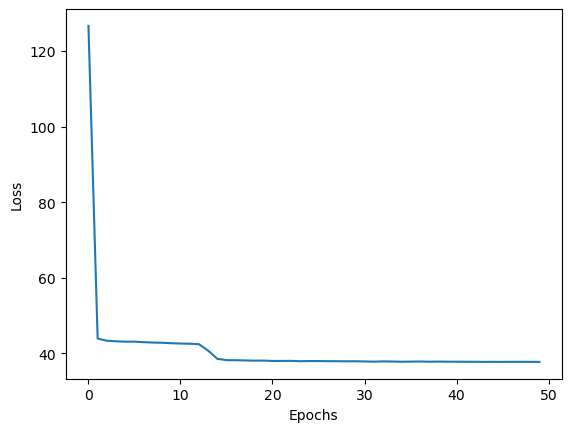

In [55]:
# Train the model for 50 epochs
name = 'pnn_80_25_1_E'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Making Predictions

In [347]:
name = 'pnn_80_25_1_E'
valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()

    df = pd.DataFrame()
    for i in range(1000):
        df[i] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], verbose=0).flatten()

    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = df.std(axis=1).to_numpy()

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['error_' + str(size)] = 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]


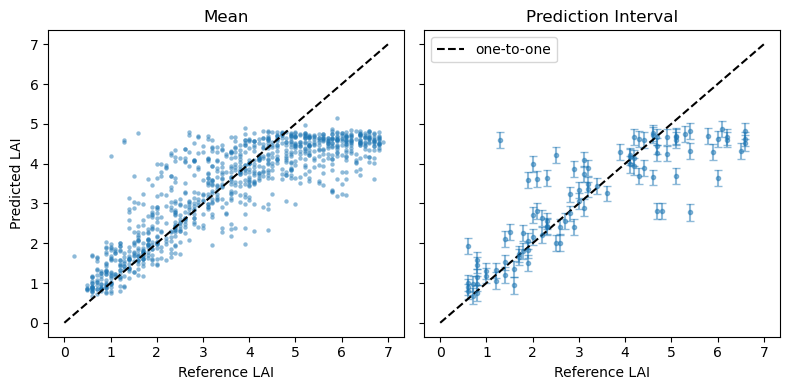

In [364]:
name = 'pnn_80_25_1_E'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], 10), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_100'], 10), np.divide(valbiomeDictLAI[biome][name]['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

plt.legend()
plt.show()

### Aleatoric and Epistemic Uncertainty

#### Defining the Model
To build a network that is capable of modeling both **aleatoric** and **epistemic** uncertainity, we will need to combine **variational layers** with a **distribution layer**. 

Again, the first layer of our model will normalize our input data. The next two layers are the same as our epistemic uncertainity model. We will use the same prior and posterior functions that we have previously defined. The third `DenseVariational()` layer is very similar as well except we will specify the number of units with `.params_size()` like we did in the aleatoric model. The last layer is the same as our aleatoric model, where we will return a distribution object.

Our loss function is the same `negloglik` that we defined before, and we will compile the model in the same way.

In [58]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_80_25_1'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=80,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=25,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_variational_18 (Dense  (None, 80)               1440      
 Variational)                                                    
                                                                 
 dense_variational_19 (Dense  (None, 25)               6075      
 Variational)                                                    
                                                                 
 dense_variational_20 (Dense  (None, 2)                156       
 Variational)                                                    
                                                                 
 distribution_lambda_3 (Dist  ((None, 1),            

#### Training the Model
We will train the model for 50 epochs and plot the loss function to confirm that the algorithm has converged.

Epoch 1/50
11771/11771 [==============================] - 64s 5ms/step - loss: 77.4260 - root_mean_squared_error: 29.5078
Epoch 2/50
11771/11771 [==============================] - 57s 5ms/step - loss: 3.8978 - root_mean_squared_error: 18.3394
Epoch 3/50
11771/11771 [==============================] - 55s 5ms/step - loss: 3.5530 - root_mean_squared_error: 13.8176
Epoch 4/50
11771/11771 [==============================] - 55s 5ms/step - loss: 3.5240 - root_mean_squared_error: 13.5248
Epoch 5/50
11771/11771 [==============================] - 73s 6ms/step - loss: 3.4530 - root_mean_squared_error: 12.8108
Epoch 6/50
11771/11771 [==============================] - 117s 10ms/step - loss: 3.4304 - root_mean_squared_error: 12.4519
Epoch 7/50
11771/11771 [==============================] - 117s 10ms/step - loss: 3.4215 - root_mean_squared_error: 12.3067
Epoch 8/50
11771/11771 [==============================] - 119s 10ms/step - loss: 3.4172 - root_mean_squared_error: 12.2972
Epoch 9/50
11771/11771 [=

Text(0, 0.5, 'Loss')

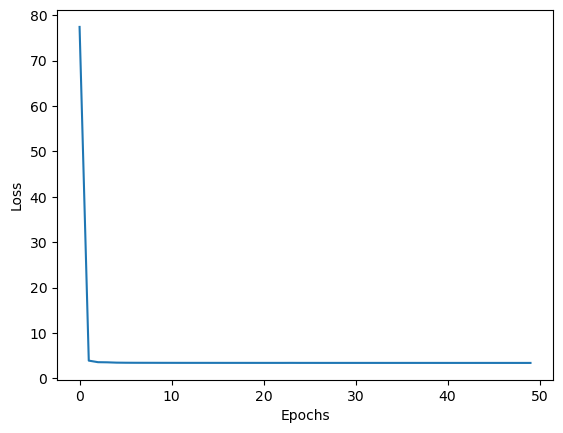

In [59]:
# Train the model for 50 epochs
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Making Predictions

In [366]:
name = 'pnn_80_25_1'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['error_' + str(size)] = 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]

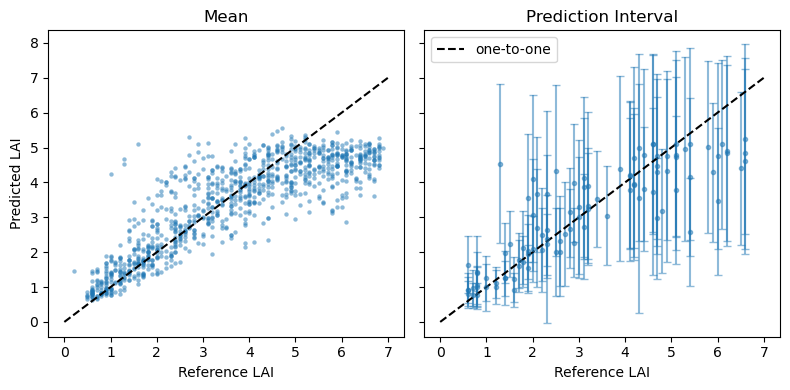

In [367]:
name = 'pnn_80_25_1'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], 10), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_100'], 10), np.divide(valbiomeDictLAI[biome][name]['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

plt.legend()
plt.show()

### TriL: Regular Neural Network

#### Defining the Model

In [254]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'nn_8_2_1'
biome = 7

# Create a new dictionary to save the Network
valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    layers.Dense(units=1)
])

# Compile the model with the specified loss and optimizer functions
valbiomeDictLAI[biome][name]['model'].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 8)                 48        
                                                                 
 dense_19 (Dense)            (None, 2)                 18        
                                                                 
 dense_20 (Dense)            (None, 1)                 3         
                                                                 
Total params: 72
Trainable params: 69
Non-trainable params: 3
_________________________________________________________________


#### Training the Model

Epoch 1/50
11771/11771 [==============================] - 58s 5ms/step - loss: 73.8097 - root_mean_squared_error: 8.5913
Epoch 2/50
11771/11771 [==============================] - 61s 5ms/step - loss: 73.7047 - root_mean_squared_error: 8.5851
Epoch 3/50
11771/11771 [==============================] - 72s 6ms/step - loss: 73.7529 - root_mean_squared_error: 8.5880
Epoch 4/50
11771/11771 [==============================] - 75s 6ms/step - loss: 73.7432 - root_mean_squared_error: 8.5874
Epoch 5/50
11771/11771 [==============================] - 72s 6ms/step - loss: 73.7373 - root_mean_squared_error: 8.5870
Epoch 6/50
11771/11771 [==============================] - 73s 6ms/step - loss: 73.6899 - root_mean_squared_error: 8.5843
Epoch 7/50
11771/11771 [==============================] - 82s 7ms/step - loss: 73.6981 - root_mean_squared_error: 8.5848
Epoch 8/50
11771/11771 [==============================] - 81s 7ms/step - loss: 73.6054 - root_mean_squared_error: 8.5794
Epoch 9/50
11771/11771 [========

Text(0, 0.5, 'Loss')

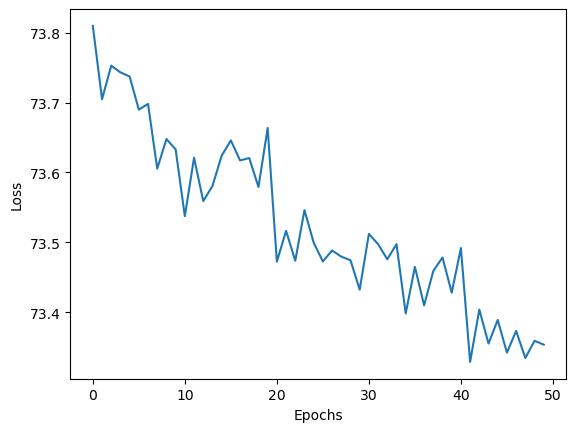

In [258]:
# Train the model for 50 epochs
name = 'nn_8_2_1'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Making Predictions

In [386]:
name = 'nn_8_2_1'
biome = 7

valSize = [100, 1000]

for size in valSize: 
    valbiomeDictLAI[biome][name]['y_pred_' + str(size)] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)]).flatten()

32/32 [==============================] - 0s 3ms/step


32/32 [==============================] - 0s 2ms/step


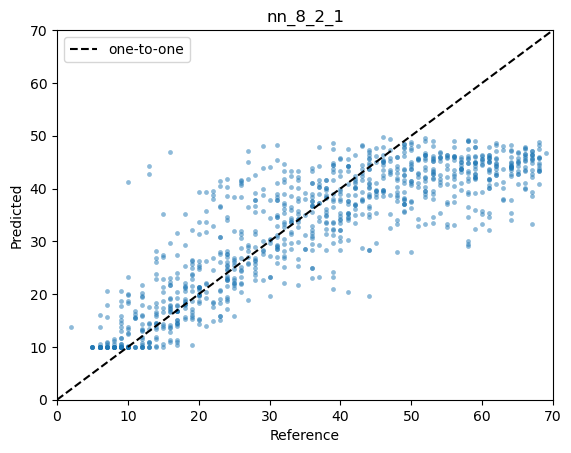

In [387]:
name = 'nn_8_2_1'
biome = 7

valbiomeDictLAI[biome][name]['y_pred_1000'] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_1000']).flatten()

plt.scatter(valbiomeDictLAI[biome]['y_test_1000'], valbiomeDictLAI[biome][name]['y_pred_1000'], alpha=0.5, s=12, lw=0)
plt.plot([0, 70], [0, 70], 'k--', label='one-to-one')

plt.xlabel("Reference")
plt.ylabel("Predicted")
plt.title(name)

plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend()
plt.show()

### TriL: Aleatoric Uncertainty

#### Defining the Model

In [265]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_A'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    layers.Dense(units=2),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 8)                 48        
                                                                 
 dense_25 (Dense)            (None, 2)                 18        
                                                                 
 dense_26 (Dense)            (None, 2)                 6         
                                                                 
 distribution_lambda_7 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 75
Trainable params: 72
Non-trainable p

#### Training the Model

Epoch 1/50
11771/11771 [==============================] - 45s 4ms/step - loss: 10.7673 - root_mean_squared_error: 17.3147
Epoch 2/50
11771/11771 [==============================] - 45s 4ms/step - loss: 3.6262 - root_mean_squared_error: 14.5762
Epoch 3/50
11771/11771 [==============================] - 54s 5ms/step - loss: 3.5684 - root_mean_squared_error: 14.1541
Epoch 4/50
11771/11771 [==============================] - 63s 5ms/step - loss: 3.5216 - root_mean_squared_error: 13.6409
Epoch 5/50
11771/11771 [==============================] - 64s 5ms/step - loss: 3.4851 - root_mean_squared_error: 13.2823
Epoch 6/50
11771/11771 [==============================] - 61s 5ms/step - loss: 3.4812 - root_mean_squared_error: 13.2538
Epoch 7/50
11771/11771 [==============================] - 60s 5ms/step - loss: 3.4803 - root_mean_squared_error: 13.2538
Epoch 8/50
11771/11771 [==============================] - 65s 5ms/step - loss: 3.4791 - root_mean_squared_error: 13.2799
Epoch 9/50
11771/11771 [=======

Text(0, 0.5, 'Loss')

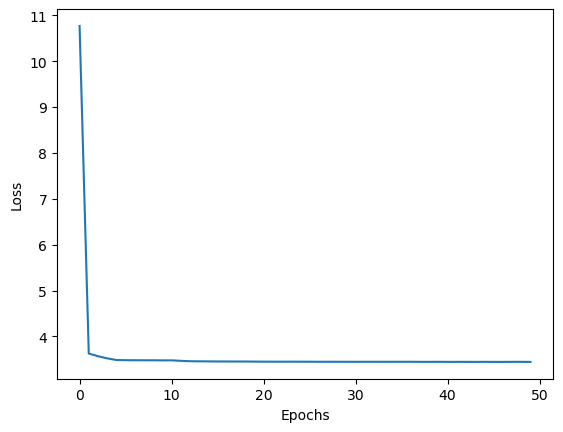

In [266]:
# Train the model for 50 epochs
name = 'pnn_8_2_1_A'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Making Predictions

In [370]:
name = 'pnn_8_2_1_A'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['error_' + str(size)] = 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]

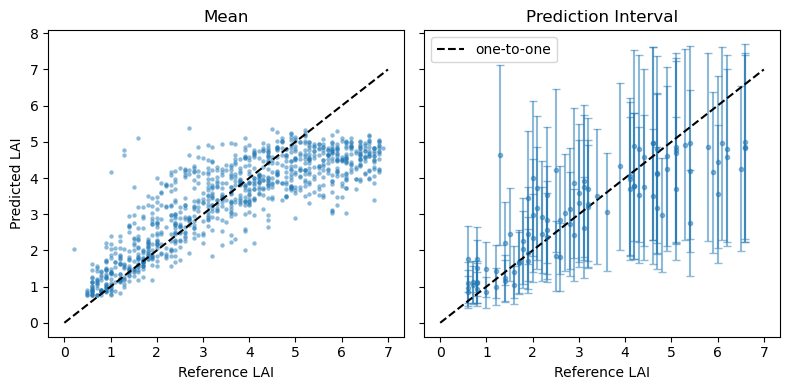

In [371]:
name = 'pnn_8_2_1_A'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], 10), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_100'], 10), np.divide(valbiomeDictLAI[biome][name]['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

plt.legend()
plt.show()

### TriL: Epistemic Uncertainty

#### Prior Distribution
We used `MultivariateNormalDiag()` (a multivariate normal distribution wtih a diagonal covariance matrix), with zero mean (`loc=tf.zeros(n)`) and a standard deviation of 1 (`scale_diag=tf.ones(n)`). Then we use the `DistrubtionLambda()` function to transform the distribution object into a Keras-compatible layer, and inject it into a `keras.Sequantial()` model. 

In [284]:
# Prior - diagonal MVN ~ N(0, 1)
def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=tf.ones(n)))
    ])

#### Posterior Distribution
Unlike the prior distribution, we want the posterior to be trainable. We will use a multivariate Gaussian distribution, but allows off-diagonal elements in the covariance matrix to be non-zero. 
There are 3 ways to parameterize such a distribution:
1. in terms of a positive definite covariance matrix
2. via a positive definite precision matrix
3. with a lower-triangular matrix with positive-valued diagonal entries (can be obtained via **Cholesky decomposition**)

In this case, we use method 3 with `MultivariateNromalTriL()` (*TriL* stands for *triangular lower*). We will use `VariableLayer()` that generates a trainable variable to parametrize `MultivariateNromalTriL()`, using `.params_size()` to get a precise number of parameters necessary.

In [285]:
# Posterior
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])

#### Defining the Model

In [313]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1_E'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.))
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_variational_39 (Dense  (None, 8)                1272      
 Variational)                                                    
                                                                 
 dense_variational_40 (Dense  (None, 2)                207       
 Variational)                                                    
                                                                 
 dense_variational_41 (Dense  (None, 1)                12        
 Variational)                                                    
                                                                 
 distribution_lambda_10 (Dis  ((None, 1),            

#### Training the Model

Epoch 1/50
11771/11771 [==============================] - 60s 5ms/step - loss: 94.2570 - root_mean_squared_error: 13.7006
Epoch 2/50
11771/11771 [==============================] - 45s 4ms/step - loss: 60.0602 - root_mean_squared_error: 10.9204
Epoch 3/50
11771/11771 [==============================] - 45s 4ms/step - loss: 56.5813 - root_mean_squared_error: 10.5974
Epoch 4/50
11771/11771 [==============================] - 55s 5ms/step - loss: 54.1849 - root_mean_squared_error: 10.3675
Epoch 5/50
11771/11771 [==============================] - 111s 9ms/step - loss: 52.1380 - root_mean_squared_error: 10.1726
Epoch 6/50
11771/11771 [==============================] - 95s 8ms/step - loss: 51.2861 - root_mean_squared_error: 10.0857
Epoch 7/50
11771/11771 [==============================] - 73s 6ms/step - loss: 50.7203 - root_mean_squared_error: 10.0315
Epoch 8/50
11771/11771 [==============================] - 53s 5ms/step - loss: 50.1398 - root_mean_squared_error: 9.9705
Epoch 9/50
11771/11771 [

Text(0, 0.5, 'Loss')

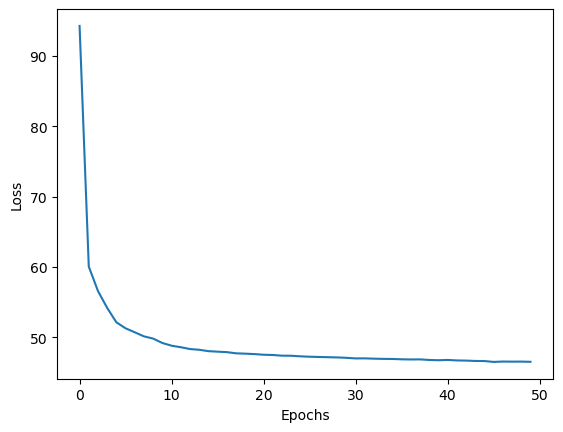

In [314]:
# Train the model for 50 epochs
name = 'pnn_8_2_1_E'
biome = 7

valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Making Predictions

In [373]:
name = 'pnn_8_2_1_E'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])
    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()

    df = pd.DataFrame()
    for i in range(1000):
        df[i] = valbiomeDictLAI[biome][name]['model'].predict(valbiomeDictLAI[biome]['X_test_' + str(size)], verbose=0).flatten()

    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = df.std(axis=1).to_numpy()

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['error_' + str(size)] = 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]


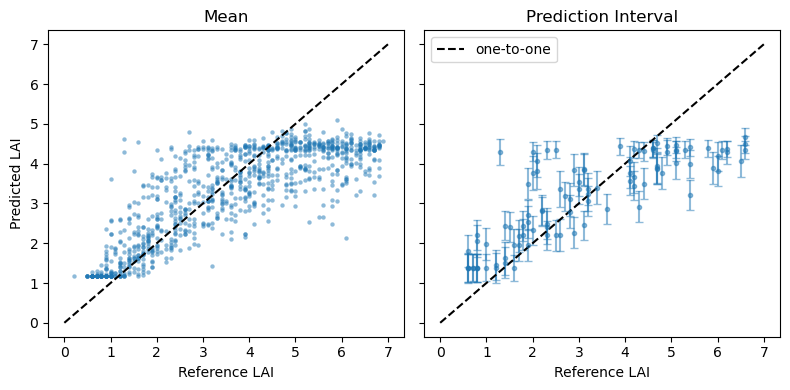

In [374]:
name = 'pnn_8_2_1_E'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], 10), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_100'], 10), np.divide(valbiomeDictLAI[biome][name]['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

plt.legend()
plt.show()

### TriL: Aleatoric and Epistemic Uncertainty

#### Defining the Model

In [319]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer

name = 'pnn_8_2_1'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=2,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[biome]['X_train'].shape[0],
                          kl_use_exact=False),
    tfpl.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

valbiomeDictLAI[biome][name]['model'].compile(loss=negloglik, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                3         
 ion)                                                            
                                                                 
 dense_variational_42 (Dense  (None, 8)                1272      
 Variational)                                                    
                                                                 
 dense_variational_43 (Dense  (None, 2)                207       
 Variational)                                                    
                                                                 
 dense_variational_44 (Dense  (None, 2)                33        
 Variational)                                                    
                                                                 
 distribution_lambda_11 (Dis  ((None, 1),            

#### Training the Model

Epoch 1/50
11771/11771 [==============================] - 60s 5ms/step - loss: 26.5696 - root_mean_squared_error: 18.3869
Epoch 2/50
11771/11771 [==============================] - 54s 5ms/step - loss: 3.9224 - root_mean_squared_error: 18.0983
Epoch 3/50
11771/11771 [==============================] - 51s 4ms/step - loss: 3.7665 - root_mean_squared_error: 16.1903
Epoch 4/50
11771/11771 [==============================] - 51s 4ms/step - loss: 3.7124 - root_mean_squared_error: 15.6649
Epoch 5/50
11771/11771 [==============================] - 55s 5ms/step - loss: 3.6854 - root_mean_squared_error: 15.3063
Epoch 6/50
11771/11771 [==============================] - 79s 7ms/step - loss: 3.6646 - root_mean_squared_error: 15.0983
Epoch 7/50
11771/11771 [==============================] - 74s 6ms/step - loss: 3.6486 - root_mean_squared_error: 14.9142
Epoch 8/50
11771/11771 [==============================] - 73s 6ms/step - loss: 3.6444 - root_mean_squared_error: 14.8911
Epoch 9/50
11771/11771 [=======

Text(0, 0.5, 'Loss')

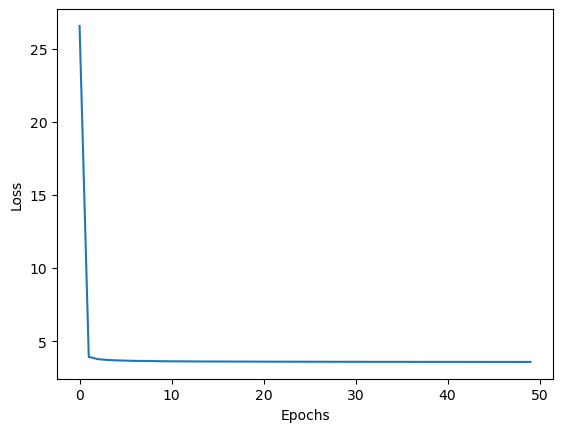

In [320]:
name = 'pnn_8_2_1'
biome = 7
# Train the model for 50 epochs
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Making Predictions

In [368]:
name = 'pnn_8_2_1'
biome = 7

valSize = [100, 1000]

for size in valSize:
    valbiomeDictLAI[biome][name]['y_model_' + str(size)] = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test_' + str(size)])

    valbiomeDictLAI[biome][name]['mean_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].mean().numpy().flatten()
    valbiomeDictLAI[biome][name]['stddev_' + str(size)] = valbiomeDictLAI[biome][name]['y_model_' + str(size)].stddev().numpy().flatten()

    valbiomeDictLAI[biome][name]['lower_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] - 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['upper_' + str(size)] = valbiomeDictLAI[biome][name]['mean_' + str(size)] + 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]
    valbiomeDictLAI[biome][name]['error_' + str(size)] = 2 * valbiomeDictLAI[biome][name]['stddev_' + str(size)]

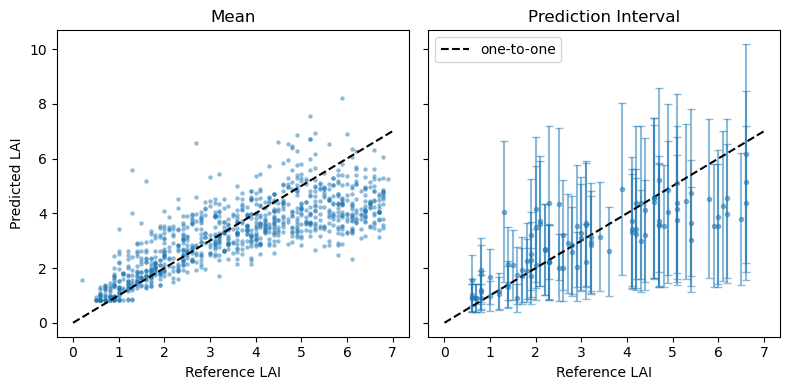

In [372]:
name = 'pnn_8_2_1'
biome = 7

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['y_test_1000'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_1000'], 10), s=10, alpha=0.5, lw=0)
axes[0].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[0].set_xlabel("Reference LAI")
axes[0].set_ylabel("Predicted LAI")
axes[0].set_title('Mean')

axes[1].errorbar(np.divide(valbiomeDictLAI[biome]['y_test_100'], 10), np.divide(valbiomeDictLAI[biome][name]['mean_100'], 10), np.divide(valbiomeDictLAI[biome][name]['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1].plot([0, 7], [0, 7], 'k--', label='one-to-one')

axes[1].set_xlabel("Reference LAI")
axes[1].set_title('Prediction Interval')

# plt.xlim([0, 7])
# plt.ylim([0, 7])

fig.tight_layout()

plt.legend()
plt.show()

### Analysis

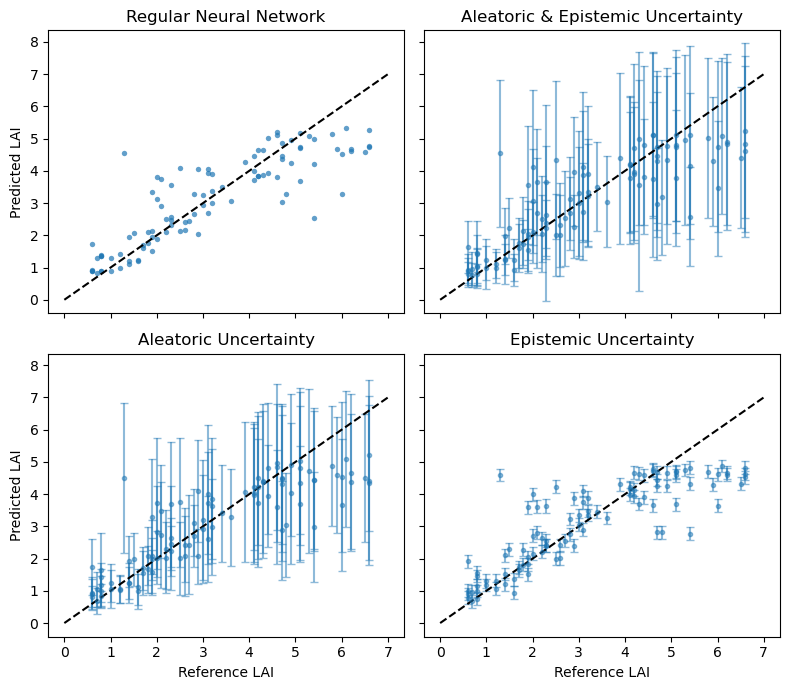

In [375]:
fig, axes = plt.subplots(2, 2, figsize=(8,7), sharey=True, sharex=True)

reference = (valbiomeDictLAI[biome]['y_test_100'].divide(10))

axes[0,0].scatter(reference, np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_100'], 10), s=15, alpha=0.7, lw=0)
axes[0,0].set_ylabel("Predicted LAI")
axes[0,0].set_title("Regular Neural Network")
axes[0,0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0,1].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_100'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[0,1].set_title("Aleatoric & Epistemic Uncertainty")
axes[0,1].plot([0, 7], [0, 7], 'k--')

axes[1,0].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['mean_100'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1,0].set_xlabel("Reference LAI")
axes[1,0].set_ylabel("Predicted LAI")
axes[1,0].set_title("Aleatoric Uncertainty")
axes[1,0].plot([0, 7], [0, 7], 'k--')

axes[1,1].errorbar(reference, np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['mean_100'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['error_100'], 10), fmt='o', ms=3, alpha=0.5, capsize=3)
axes[1,1].set_xlabel("Reference LAI")
axes[1,1].set_title("Epistemic Uncertainty")
axes[1,1].plot([0, 7], [0, 7], 'k--')

fig.tight_layout()

Fig. 1 

{}


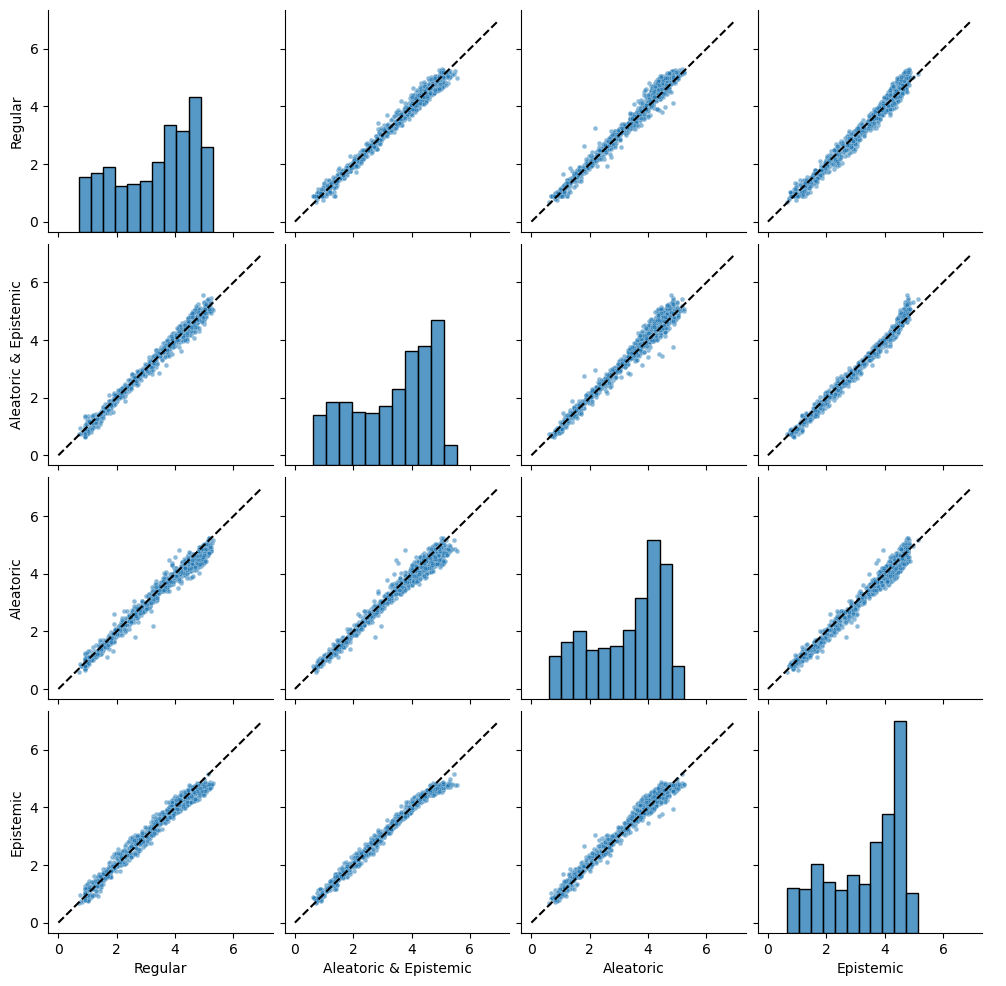

In [376]:
df = pd.DataFrame(data={
    'Regular': np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_1000'], 10),
    'Aleatoric & Epistemic': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_1000'], 10),
    'Aleatoric': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['mean_1000'], 10),
    'Epistemic': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['mean_1000'], 10)
})

def plot_unity(x, y, **kwargs):
    points = np.linspace(0, 7, 100)
    plt.plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.5)

grid = sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.5, 's': 12, 'lw':0})
grid.map_offdiag(plot_unity, label='1:1 Line')
grid.add_legend()
print(grid._legend_data)

Fig. 2

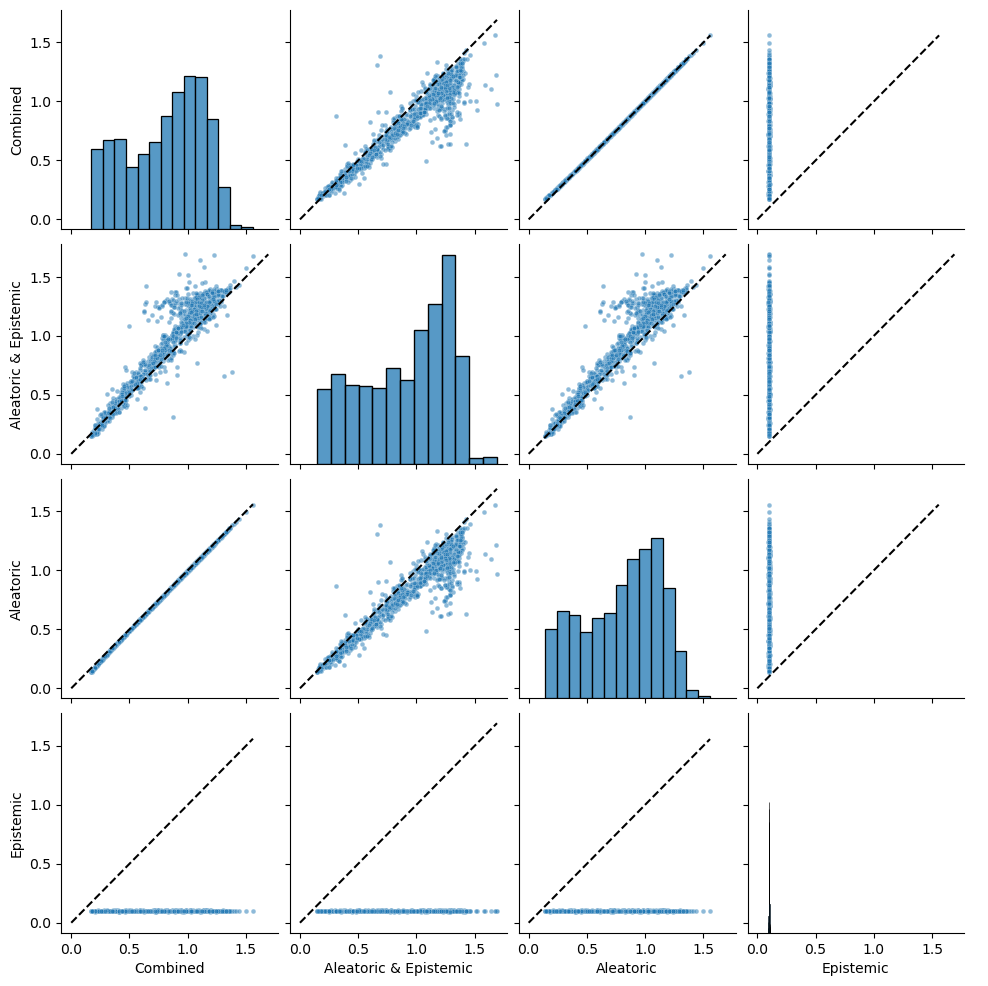

In [377]:
df = pd.DataFrame(data={
    'Combined': np.divide(np.sqrt(np.add(np.square(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000']), np.square(valbiomeDictLAI[biome]['pnn_80_25_1_E']['stddev_1000']))), 10),
    'Aleatoric & Epistemic': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_1000'], 10),
    'Aleatoric': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000'], 10),
    'Epistemic': np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['stddev_1000'], 10)
})

def plot_unity(x, y, **kwargs):
    mx = max(x.max(), y.max())
    points = np.linspace(0, mx, 100)
    plt.plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.5)

grid = sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.5, 's': 12, 'lw':0})
grid.map_offdiag(plot_unity, label='1:1 Line')
grid.add_legend()

Fig. 3

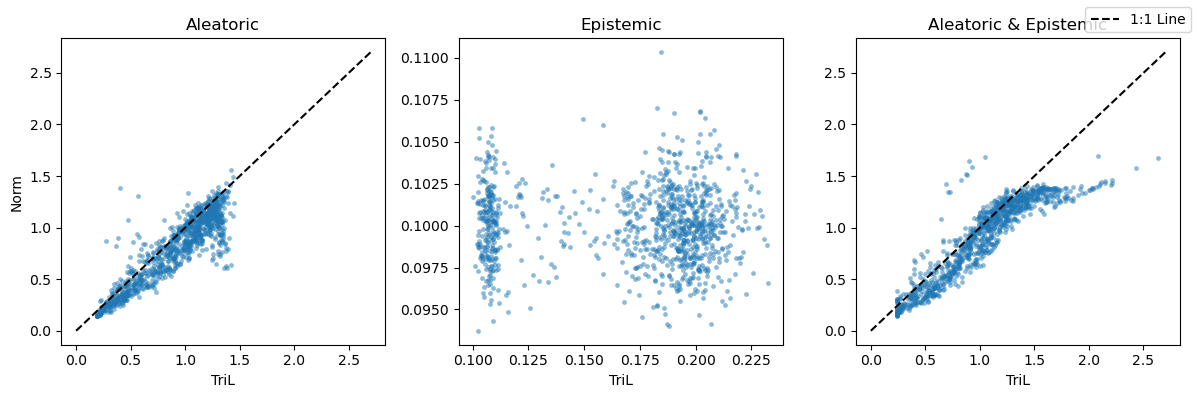

In [384]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

axes[0].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_A']['stddev_1000'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['stddev_1000'], 10), alpha=0.5, s=12, lw=0)
axes[0].plot([0, 2.7], [0, 2.7], 'k--')
axes[0].set_xlabel("TriL")
axes[0].set_ylabel("Norm")
axes[0].set_title("Aleatoric")

axes[1].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_E']['stddev_1000'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['stddev_1000'], 10), alpha=0.5, s=12, lw=0)
# axes[1].plot([0, 2.7], [0, 2.7], 'k--')
axes[1].set_xlabel("TriL")
axes[1].set_title("Epistemic")

axes[2].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1']['stddev_1000'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['stddev_1000'], 10), alpha=0.5, s=12, lw=0)
axes[2].plot([0, 2.7], [0, 2.7], 'k--', label='1:1 Line')
axes[2].set_xlabel("TriL")
axes[2].set_title("Aleatoric & Epistemic")

fig.legend()
plt.tight_layout()
plt.show()

Figure 4

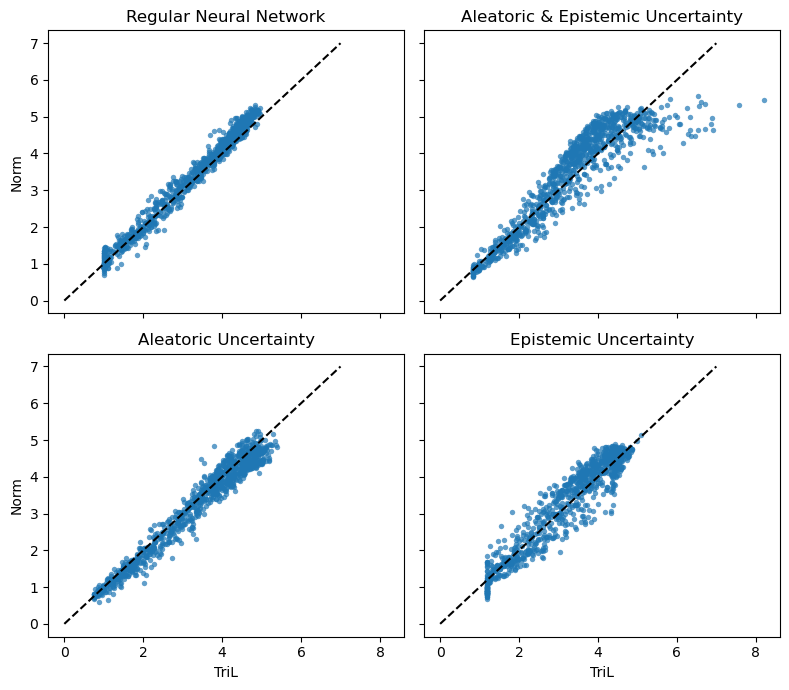

In [389]:
fig, axes = plt.subplots(2, 2, figsize=(8,7), sharey=True, sharex=True)

axes[0,0].scatter(np.divide(valbiomeDictLAI[biome]['nn_8_2_1']['y_pred_1000'], 10), np.divide(valbiomeDictLAI[biome]['nn_80_25_1']['y_pred_1000'], 10), s=15, alpha=0.7, lw=0)
axes[0,0].set_ylabel("Norm")
axes[0,0].set_title("Regular Neural Network")
axes[0,0].plot([0, 7], [0, 7], 'k--', label='1:1 Line')

axes[0,1].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1']['mean_1000'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1']['mean_1000'], 10), s=15, alpha=0.7, lw=0)
axes[0,1].set_title("Aleatoric & Epistemic Uncertainty")
axes[0,1].plot([0, 7], [0, 7], 'k--')

axes[1,0].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_A']['mean_1000'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_A']['mean_1000'], 10), s=15, alpha=0.7, lw=0)
axes[1,0].set_xlabel("TriL")
axes[1,0].set_ylabel("Norm")
axes[1,0].set_title("Aleatoric Uncertainty")
axes[1,0].plot([0, 7], [0, 7], 'k--')

axes[1,1].scatter(np.divide(valbiomeDictLAI[biome]['pnn_8_2_1_E']['mean_1000'], 10), np.divide(valbiomeDictLAI[biome]['pnn_80_25_1_E']['mean_1000'], 10), s=15, alpha=0.7, lw=0)
axes[1,1].set_xlabel("TriL")
axes[1,1].set_title("Epistemic Uncertainty")
axes[1,1].plot([0, 7], [0, 7], 'k--')

fig.tight_layout()

## Questions
1. Which predictor is better in general in terms of RMSE  and bias overall and for unsaturated and saturated validation samples.
2. What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)
3. What is the relative size of the standard deviation of LAI or fAPAR absolute residual to the prediction confidence interval
4. Does the prediction confidence interval change as the sample size decreases?

In [ ]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df_100'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            'rmse': metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_' + predictor], squared=False),
            'residual': valbiomeDictLAI[biome]['DF']['y_' + predictor] - valbiomeDictLAI[biome]['y_test'],
            # 'stddev': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'pi_mag': valbiomeDictLAI[biome]['DF']['upper'] - valbiomeDictLAI[biome]['DF']['lower'],
            'sample_size': 100,
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df_100'] = pd.concat([valbiomeDictLAI[biome]['result_df'], df])

### Question 1
Which predictor is better in general in terms of RMSE and bias overall and for unsaturated and saturated validation samples. 

In [174]:
valbiomeDictLAI[biome]['rf']['rmse'] = metrics.mean_squared_error(valbiomeDictLAI[biome]['y_test'], valbiomeDictLAI[biome]['rf']['y_pred'], squared=False)
valbiomeDictLAI[biome]['nn_80_25_1']['rmse'] = metrics.mean_squared_error(valbiomeDictLAI[biome]['y_test'], valbiomeDictLAI[biome]['nn_80_25_1']['y_pred'], squared=False)

valbiomeDictLAI[biome]['rf']['mse'], valbiomeDictLAI[biome]['rf']['bias'], valbiomeDictLAI[biome]['rf']['variance'] = bias_variance_decomp(valbiomeDictLAI[biome]['rf']['model'], calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'], valbiomeDictLAI[biome]['X_test'], valbiomeDictLAI[biome]['y_test'], loss='mse', num_rounds=50)
valbiomeDictLAI[biome]['nn_80_25_1']['mse'], valbiomeDictLAI[biome]['nn_80_25_1']['bias'], valbiomeDictLAI[biome]['nn_80_25_1']['variance'] = bias_variance_decomp(valbiomeDictLAI[biome]['nn_80_25_1']['model'], calbiomeDictLAI[biome]['X_train'], calbiomeDictLAI[biome]['y_train'], valbiomeDictLAI[biome]['X_test'], valbiomeDictLAI[biome]['y_test'], loss='mse', num_rounds=50)

KeyError: 'nn_80_25_1'

In [ ]:
# Scatter plots (with 1000 samples only) of each estimated versus predicted together
fig, axs = plt.subplots(1,2)
axs[0].scatter(x=valbiomeDictLAI[biome]['y_test'], y=valbiomeDictLAI[biome]['rf']['y_pred'])
axs[1].scatter(x=valbiomeDictLAI[biome]['y_test'], y=valbiomeDictLAI[biome]['nn_80_25_1']['y_pred'])

axs[0].set_title("Random Forest")
axs[0].set_xlabel("Reference")
axs[0].set_ylabel("Predicted")

axs[1].set_title("Neural Network")
axs[1].set_xlabel("Reference")
axs[1].set_ylabel("Predicted")

axs[0].plot([-10, 80], [-10, 80], 'k--', label='one-to-one')
axs[0].xlim([-10, 80])
axs[0].ylim([-10, 80])

axs[1].plot([-10, 80], [-10, 80], 'k--')
axs[1].xlim([-10, 80])
axs[1].ylim([-10, 80])

axs[0].text('RMSE:', 

### Question 2
What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
fig, axs = plt.subplots(2,2)
axs[0,0].scatter(x=valbiomeDictLAI[biome]['y_test'], y=valbiomeDictLAI[biome]['y_rfr'])
axs[0,1].scatter(x=valbiomeDictLAI[biome]['y_test'] - valbiomeDictLAI[biome]['y_rfr'], y=valbiomeDictLAI[biome]['stddev_rfr'])
axs[1,0].scatter(x=valbiomeDictLAI[biome]['y_test'], y=valbiomeDictLAI[biome]['y_pnn'])
axs[1,1].scatter(x=valbiomeDictLAI[biome]['y_test'] - valbiomeDictLAI[biome]['y_pnn'], y=valbiomeDictLAI[biome]['stddev_pnn'])

plt.plot([-10, 80], [-10, 80], 'k--')
plt.xlim([-10, 80])
plt.ylim([-10, 80])
plt.plot([0, 80], [0, 0], 'k--')

### Question 3
What is the relative size of the standard deviation of LAI or fAPAR  absolute residual to the  prediction confidence interval

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.


### Question 4
Does the prediction confidence interval change as the sample size decreases?  

In [ ]:
# Sample 50% of the calibration data
for i in biomes:
    calbiomeDictLAI[i]['X_train_50'] = calbiomeDictLAI[i]['X_train'].sample(frac=0.5)
    calbiomeDictLAI[i]['y_train_50'] = calbiomeDictLAI[i]['y_train'].sample(frac=0.5)

In [ ]:
# Create and fit a Random Forest Quantile Regressor using 50% of the calibration samples
for i in biomes:
    valbiomeDictLAI[i]['rfqr_50'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rfqr_50'].set_params(max_features=calbiomeDictLAI[i]['X_train_50'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr_50'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train_50'], calbiomeDictLAI[i]['y_train_50'])

In [ ]:
# Predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['DF']['upper_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['DF']['lower_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['DF']['mid_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

In [ ]:
# Create and fit a Neural Network using 50% of the calibration samples

In [ ]:
# Predicting a Neural Network for each biome type with 95% prediction confidence interval

In [ ]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df_50'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            'rmse': metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_' + predictor], squared=False),
            'residual': valbiomeDictLAI[biome]['DF']['y_' + predictor] - valbiomeDictLAI[biome]['y_test'],
            # 'sd': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'pi_mag': valbiomeDictLAI[biome]['DF']['upper_50'] - valbiomeDictLAI[biome]['DF']['lower_50'],
            'sample_size': 50,
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df_50'] = pd.concat([valbiomeDictLAI[biome]['result_df_50'], df])

In [ ]:
# Plot the prediction confidence intervals magnitude versus the true value (maybe a kde plot) for 100% and 50%
data = pd.concat([valbiomeDictLAI[biome]['result_df_50'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf'], valbiomeDictLAI[biome]['result_df_100'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf']])
sns.kdeplot(data=data, x='y_true', y='pi_mag', hue='sample_size')

In [ ]:
sns.scatterplot(data=valbiomeDictLAI[biome]['result_df_50'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf'], x='y_true', y='pi_mag')